


todo: 
* figure out why the evals are returning NaN
* write perceptual checks
* normalize robustness/make it better at the expense of perception
* separate the time and transform watermark outside the combo file
* clean code (type returns etc)


notes:
had to clone and build aquatk - pip install doesnt work yet, missing folders, so had to edit __init__ to get it working. also had to edit a lot of things. including imports and relativity. also it takes filenames, not data, so scrapped it. 

In [3]:
%load_ext autoreload
%autoreload 2

In [63]:
import soundfile as sf
import numpy as np
from IPython.display import Audio 
import pandas as pd
import librosa
import time

from globals import hop_length, qim_parameters, domain_choice, n_fft, smoothing_window, attack_names, metric_names_r, metric_names_p, watermark_names
from combo import Echo, Embeds, precalculate_frame_domains, WatermarkDCT
from utils.evaluation.evaluation import RobustnessEvaluation
from utils.watermark.util import tobits, frombits, visual_bitwise_check
from utils.evaluation.perceptual_evaluation import PerceptualEvaluation

ImportError: cannot import name 'AQUA' from 'aquatk' (/home/ara/.local/lib/python3.13/site-packages/aquatk/__init__.py)

In [1]:
from aquatk.metrics import PEAQ

PEAQ.peaq_basic.process_audio_files()

AttributeError: module 'aquatk.metrics.PEAQ' has no attribute 'peaq_basic'

In [5]:
audio,sr = sf.read("svega.wav")
if np.shape(audio)[1] == 2:
    audio = audio.mean(axis=1)

In [ ]:
# for all watermarks
flag = tobits("flag{yeah_but_also_no}")
frames = len(audio) // hop_length
repeats = (frames) // len(flag)
actual = "".join(str(bit) for bit in flag)*repeats
r = RobustnessEvaluation()
r_attacks = [r.resample, r.requantize, r.noise, r.lowpass, r.highpass, r.amplitude]
p = PerceptualEvaluation()

In [ ]:
class Results:
    attacks = attack_names
    evaluations_r = metric_names_r
    evaluations_p = metric_names_p
    watermarks = watermark_names
    column_names_r = ["audio_id", "watermark_type", "attack", "metric", "value"]
    column_names_p = ["audio_id", "watermark_type", "metric", "value"]
    results_robust = []
    results_perceptual = []

    def add_set_robust(self, audio_id, attack, wm, res):
        if attack not in self.attacks:
            print(f"attack {attack} not supported, please pick from {self.attacks}")

        for ev in res:
            if ev not in self.evaluations:
                print(f"eval metric {ev} not supported, please pick from {self.evaluations}")
                return -1
            re = res[ev]
            self.results_robust.append({
                self.column_names_r[0]: audio_id,
                self.column_names_r[1]: wm,
                self.column_names_r[2]: attack,
                self.column_names_r[3]: ev, 
                self.column_names_r[4]: re
            })

    def add_set_perceptual(self, audio_id, wm, res):
        for ev in res:
            re = res[ev]
            self.results_perceptual.append({
                self.column_names_p[0]: audio_id, 
                self.column_names_p[1]: wm,
                self.column_names_p[2]: ev, 
                self.column_names_p[3]: re
            })

    def convert_robust(self):
        self.df_robust = pd.DataFrame(self.results_robust)

    def convert_perceptual(self):
        self.df_perceptual = pd.DataFrame(self.results_perceptual)


class FullEval:
    def __init__(self, he_flag):
        # only state: flag, watermark class objects, results class
        self.flag = he_flag
        self.w_hybrid = Embeds(he_flag) # todo for all three - take sample rate here
        self.w_transform = WatermarkDCT(window_func=qim_parameters.WINDOW_FUNC, watermark=flag)
        self.w_time = Echo() # take watermark here instead of embed func
        self.results = Results()

    def _run_all_embed(self, he_designations, he_audio, he_sr):
        # hybrid embed
        wm_hybrid = self.w_hybrid.embed_combo_watermark(he_designations, he_audio, he_sr)
        wm_transform = self.w_transform.embed_qim_full(he_audio, alpha=qim_parameters.ALPHA)
        wm_time = self.w_time.full_embed_watermark(he_audio, he_sr, self.flag)

        return wm_hybrid, wm_transform, wm_time

    def _run_all_extract(self, he_designations, wm_hybrid, wm_transform, wm_time, he_sr):
        wmbits_hybrid = self.w_hybrid.extract_combo_watermark(designations=he_designations, audio=wm_hybrid, sr=he_sr)
        extracted_hybrid = bin(wmbits_hybrid)[2:].zfill(len(he_designations) - 2)

        wmbits_transform = self.w_transform.extract_watermark(wm_transform)
        extracted_transform = "".join(wmbits_transform)

        wmbits_time = self.w_time.full_extract_watermark(wm_time, he_sr)
        extracted_time = "".join(wmbits_time)

        return extracted_hybrid, extracted_transform, extracted_time
    
    def _run_all_attacks(self):
        pass
    
    def _run_all_eval_r(self, audio_id, attack, he_actual, extracted_hybrid, extracted_transform, extracted_time):
        visual_hybrid = visual_bitwise_check(he_actual, extracted_hybrid[:len(he_actual)])
        numbers_hybrid = r.eval_all(real=he_actual, extracted=extracted_hybrid[:len(he_actual)])

        visual_transform = visual_bitwise_check(he_actual, extracted_transform[:len(he_actual)])
        numbers_transform = r.eval_all(real=he_actual, extracted=extracted_transform[:len(he_actual)])

        visual_time = visual_bitwise_check(he_actual, extracted_time[:len(he_actual)])
        numbers_time = r.eval_all(real=he_actual, extracted=extracted_time[:len(he_actual)])

        self.results.add_set_robust(audio_id, attack, watermark_names[0], numbers_hybrid)
        self.results.add_set_robust(audio_id, attack, watermark_names[1], numbers_transform)
        self.results.add_set_robust(audio_id, attack, watermark_names[2], numbers_time)

        return numbers_hybrid, numbers_transform, numbers_time
    
    def _run_all_eval_p(self, audio_id, original_audio, wm_hybrid, wm_transform, wm_time):
        res_hybrid = p.evaluate_watermark(original_audio=original_audio, watermarked_audio=wm_hybrid)
        res_transform = p.evaluate_watermark(original_audio=original_audio, watermarked_audio=wm_transform)
        res_time = p.evaluate_watermark(original_audio=original_audio, watermarked_audio=wm_time)

        self.results.add_set_perceptual(audio_id=audio_id, wm=watermark_names[0], res=res_hybrid)
        self.results.add_set_perceptual(audio_id=audio_id, wm=watermark_names[1], res=res_transform)
        self.results.add_set_perceptual(audio_id=audio_id, wm=watermark_names[2], res=res_time)

        return res_hybrid, res_transform, res_time
        
        
    def run_all(self, audio_id, he_audio, he_sr):
        frames = len(audio) // hop_length
        repeats = frames // len(flag)
        actual = "".join(str(bit) for bit in flag)*repeats

        # embed all
        embed_designations = precalculate_frame_domains(he_audio, he_sr)
        wm_hybrid, wm_transform, wm_time = self._run_all_embed(he_designations=embed_designations, he_audio=he_audio, he_sr=he_sr)

        # perceptual eval
        self._run_all_eval_p(audio_id, he_audio, wm_hybrid, wm_transform, wm_time)

        # run attacks, all separately, then all together
        for at in range(len(attack_names)):
            attack = attack_names[at]

            if at != 0:
                wm_hybrid_processed = r_attacks[at - 1](audio=wm_hybrid, sr=sr)
                wm_transform_processed = r_attacks[at - 1](audio=wm_transform, sr=sr)
                wm_time_processed = r_attacks[at - 1](audio=wm_time, sr=sr)
            else:
                wm_hybrid_processed = wm_hybrid
                wm_transform_processed = wm_transform
                wm_time_processed = wm_time

            # extract all
            extract_designations = precalculate_frame_domains(wm_hybrid_processed, he_sr)
            extracted_hybrid, extracted_transform, extracted_time = self._run_all_extract(extract_designations, wm_hybrid_processed, wm_transform_processed, wm_time_processed, he_sr)

            # evaluate robustness
            self._run_all_eval_r(audio_id, attack, actual, extracted_hybrid, extracted_transform, extracted_time)
        
        

In [ ]:
# run once, then redeclare and add from saved_data.json

fe = FullEval(flag)
broke = 0


def create_data():
    for i in range(100):
        try:
            start_time = time.perf_counter()
            id = str(i).zfill(3)
            audio, sr = librosa.load(f"data/000/000{id}.mp3")
            fe.run_all(audio_id=id, he_audio=audio, he_sr=sr)
            end_time = time.perf_counter()
            print(i)
            print(end_time - start_time)
            print("")
        except:
            broke += 1
    print(broke)

create_data()

/tmp/ipykernel_1700776/2626944114.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(f"data/000/000{id}.mp3")
/home/ara/.local/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


2
20.007382862997474

3
23.477041286008898

5
25.25745299999835

10
25.503372664999915

20
30.17843509701197



/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


26
31.69740115397144

30
34.02621828898555

46
34.84822477999842

48
34.444845197023824

134
24.046304935996886

135
28.865047918021446

136
28.482698040024843

137
14.059783773001982

138
16.57623032599804

139
32.96400225700927

140
31.573792039998807

141
30.97923684201669

142
19.864914046018384

144
27.13952433099621

145
32.38376337301452

146
25.798945303977234

147
24.413613321987214

148
19.346462873974815

149
27.790477106987964

150
33.16558433001046

151
29.226570777012967

152
26.06233896498452

153
27.413646194996545

154
34.355985130008776

155
32.536669802007964

156
27.65448477602331

157
26.284690305998083

158
34.39537850502529

159
32.607113045989536

160
30.53334413401899

161
25.60804676398402

162
28.629313673998695

163
31.564493708021473

164
32.64312120602699

165
31.681099687993992

166
32.478299623995554

167
31.992898407013854

168
25.826947933004703

169
33.016744012973504

170
15.958015682001133

171
30.551039290992776

172
19.416232399002183

173
29.3733

In [54]:
import json

file_path = "saved_data.json"

# with open(file_path, "w") as f:
#     json.dump(fe.results.results, f, indent=4)

with open(file_path, "r") as f:
    f_js = f.read()
    oops = json.loads(f_js)


In [43]:
fe.results.convert()
df = fe.results.df
print(df)

      audio_id              watermark_type     attack                  metric  \
0          002     Hybrid Domain Watermark       None          Detection Rate   
1          002     Hybrid Domain Watermark       None               Precision   
2          002     Hybrid Domain Watermark       None  Normalized Correlation   
3          002     Hybrid Domain Watermark       None          Bit Error Rate   
4          002  Transform Domain Watermark       None          Detection Rate   
...        ...                         ...        ...                     ...   
25447      498  Transform Domain Watermark  Amplitude          Bit Error Rate   
25448      498       Time Domain Watermark  Amplitude          Detection Rate   
25449      498       Time Domain Watermark  Amplitude               Precision   
25450      498       Time Domain Watermark  Amplitude  Normalized Correlation   
25451      498       Time Domain Watermark  Amplitude          Bit Error Rate   

          value  
0      0.

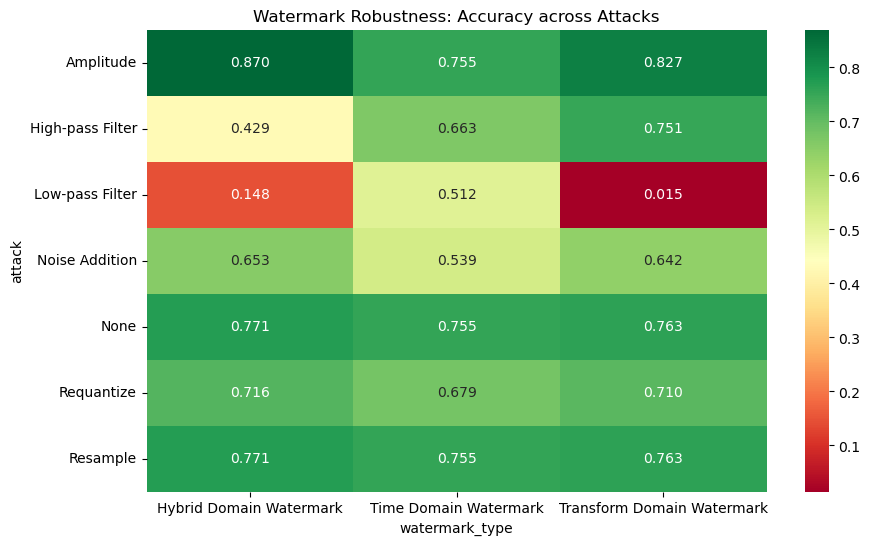

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot to show watermark performance across attacks for one metric
pivot = df[df['metric'] == metric_names[0]].pivot_table(
    values='value', 
    index='attack', 
    columns='watermark_type', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn')
plt.title('Watermark Robustness: Accuracy across Attacks')
plt.show()

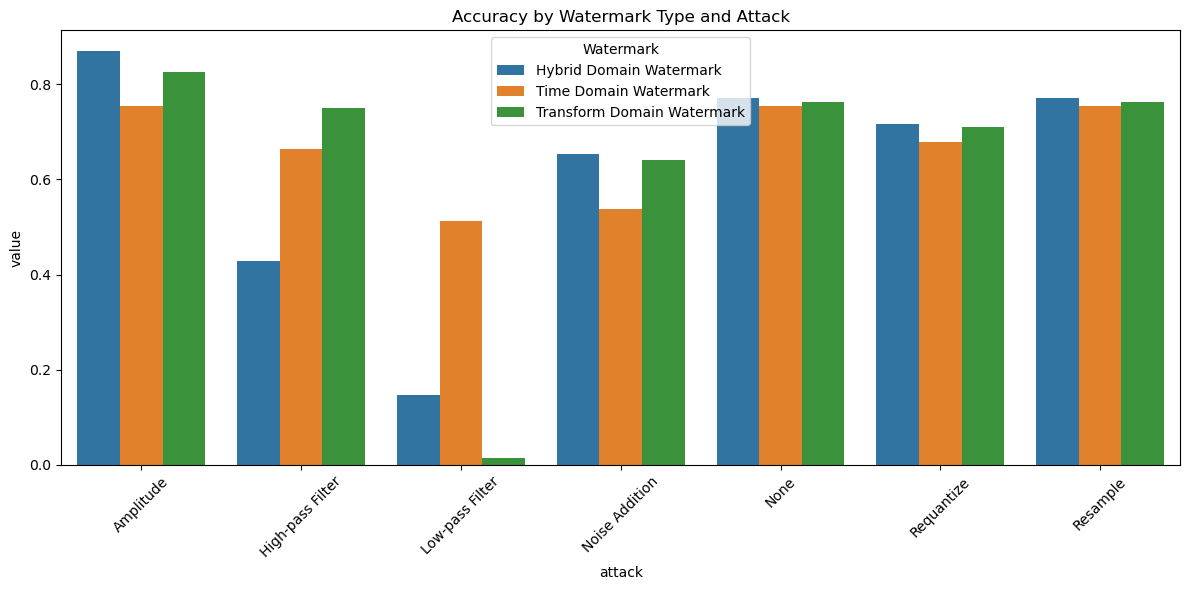

In [45]:
# Average across all audios
summary = df.groupby(['watermark_type', 'attack', 'metric'])['value'].mean().reset_index()

# Plot one metric
metric_data = summary[summary['metric'] == metric_names[0]]

plt.figure(figsize=(12, 6))
sns.barplot(data=metric_data, x='attack', y='value', hue='watermark_type')
plt.title('Accuracy by Watermark Type and Attack')
plt.xticks(rotation=45)
plt.legend(title='Watermark')
plt.tight_layout()
plt.show()

/home/ara/.local/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ara/.local/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ara/.local/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ara/.local/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

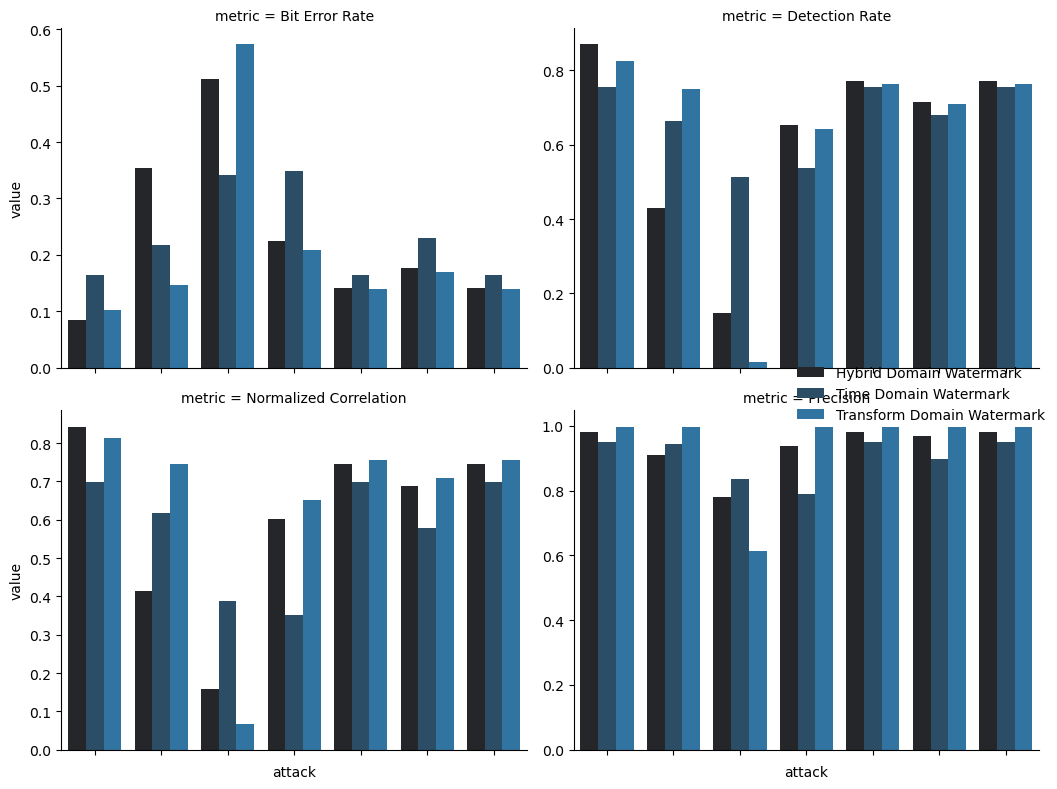

In [46]:
summary = df.groupby(['watermark_type', 'attack', 'metric'])['value'].mean().reset_index()

g = sns.FacetGrid(summary, col='metric', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.barplot, x='attack', y='value', hue='watermark_type')
g.add_legend()
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()

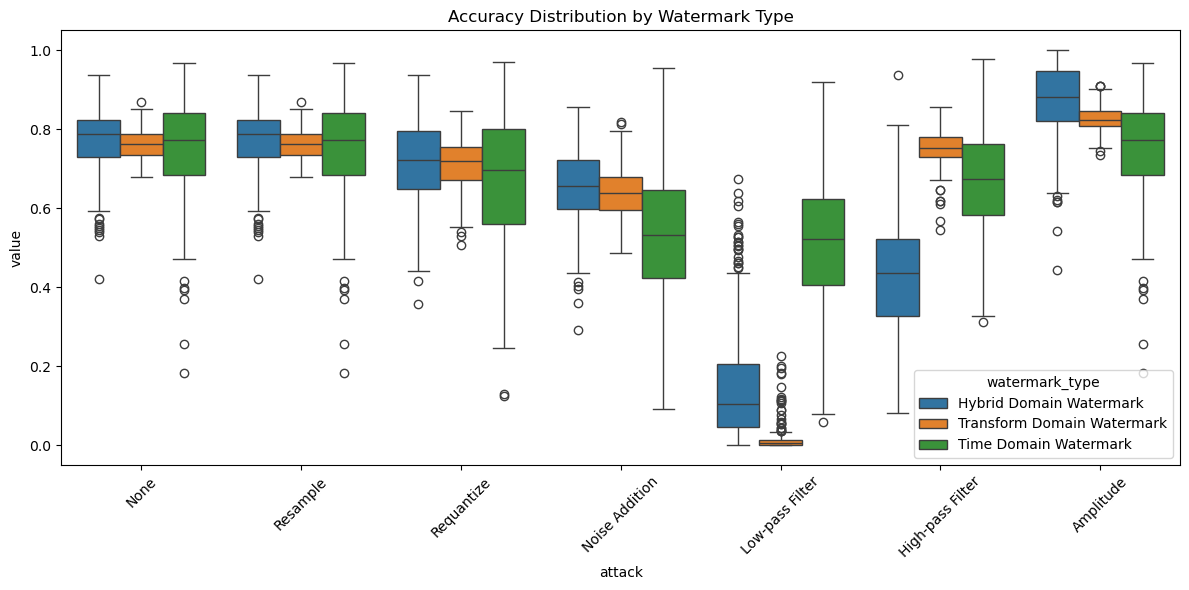

In [47]:
# Keep individual audio results to show variability
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['metric'] == metric_names[0]], 
            x='attack', y='value', hue='watermark_type')
plt.title('Accuracy Distribution by Watermark Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

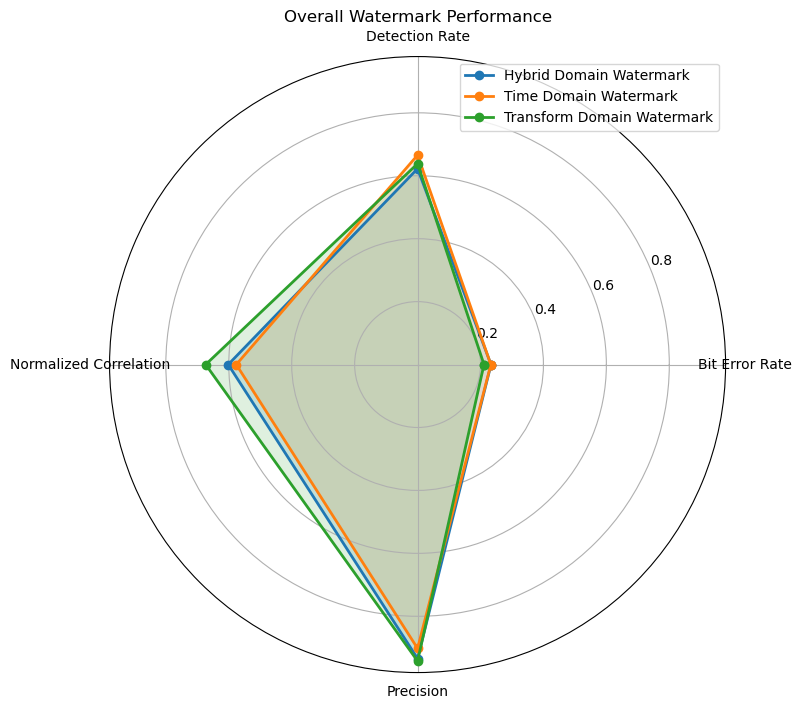

In [48]:
import numpy as np

# Average performance across all attacks for each watermark
summary = df.groupby(['watermark_type', 'metric'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

metrics = summary['metric'].unique()
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the plot

for watermark in summary['watermark_type'].unique():
    values = summary[summary['watermark_type'] == watermark]['value'].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=watermark)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.legend(loc='upper right')
plt.title('Overall Watermark Performance')
plt.show()